In [472]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('heart.csv')
df.sample(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
722,60,F,ASY,150,258,0,LVH,157,N,2.6,Flat,1
576,62,M,ASY,139,170,0,ST,120,Y,3.0,Flat,1
69,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
470,53,M,ASY,126,0,0,Normal,106,N,0.0,Flat,1
789,34,M,TA,118,182,0,LVH,174,N,0.0,Up,0
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
96,43,M,ATA,142,207,0,Normal,138,N,0.0,Up,0
244,48,M,ASY,160,268,0,Normal,103,Y,1.0,Flat,1
252,61,M,ASY,125,292,0,ST,115,Y,0.0,Up,0
55,51,F,ATA,160,194,0,Normal,170,N,0.0,Up,0


In [473]:
# Não há nenhum valor Not A Number em nosso Dataset
df.isnull().sum().sum()

0

In [474]:
df.describe(include=['O'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [475]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [476]:
numerical_features = []
for feature in df.columns:
    print(feature, df[feature].nunique())

    if(df[feature].nunique() >= 50):
        numerical_features.append(feature)

Age 50
Sex 2
ChestPainType 4
RestingBP 67
Cholesterol 222
FastingBS 2
RestingECG 3
MaxHR 119
ExerciseAngina 2
Oldpeak 53
ST_Slope 3
HeartDisease 2


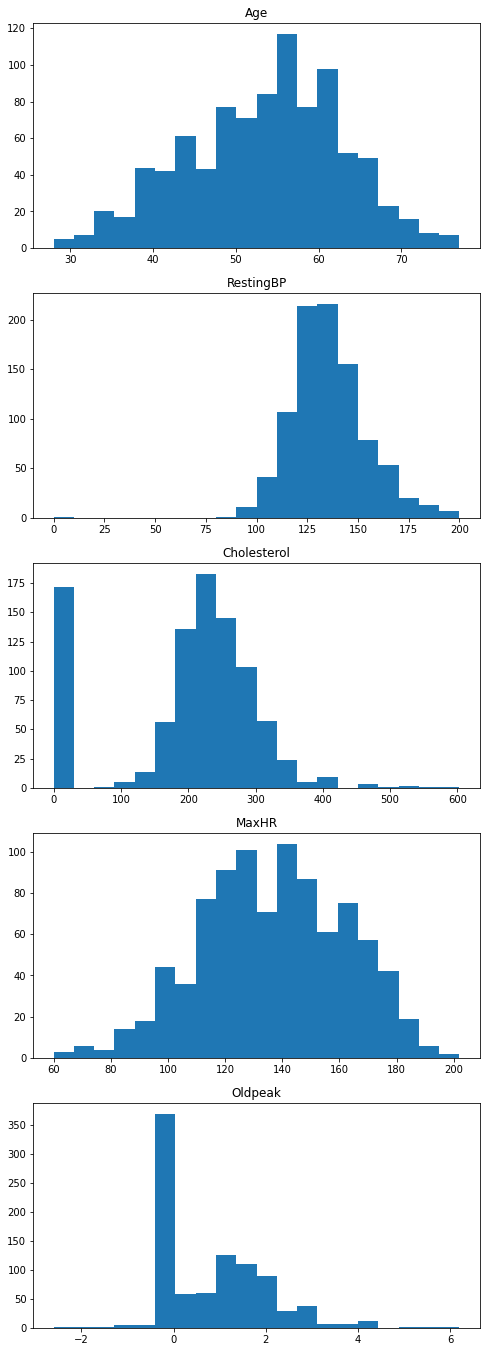

In [477]:
# Plot das features contínuas
fig,axs = plt.subplots(5,1, figsize=(8,24))

for i,feature in enumerate(numerical_features):
    axs[i].hist(df[feature], bins=20)
    axs[i].set_title(feature)

plt.show()

Como podemos visualizar no histograma da feature 'Cholesterol', há uma grande quantidade de valores nulos. Contudo, sabemos que o valor de colesterol de uma pessoa não pode ser igual a 0. Dessa forma trataremos esses dados como faltantes. A distribuição do colesterol e aparentemente simétrica e se assemelha à uma normal, portanto, vamos tentar substituir os valores faltantes pela média dos colesterois não contando com os zeros.

In [478]:
from scipy import stats

In [479]:
cholesterol_values = df['Cholesterol'].loc[df['Cholesterol'] != 0].values

k,p_value = stats.normaltest(cholesterol_values)
print(f"P valor igual a {p_value}")

P valor igual a 2.1973197491209497e-45


In [480]:
# Uma vez que o p-valor é muito baixo, não rejeitamos a hipótese nula

df['Cholesterol'].replace(0, cholesterol_values.mean(), inplace=True)

In [481]:
# Não há um grande desbalanceamento entre os dados
normal_qtd = df['HeartDisease'].value_counts()[0]
disease_qtd = df['HeartDisease'].value_counts()[1]
print(f"Percentage of normal people: {normal_qtd/(normal_qtd + disease_qtd)}")
print(f"Percentage of people with heart disease: {disease_qtd/(normal_qtd + disease_qtd)}")

Percentage of normal people: 0.4466230936819172
Percentage of people with heart disease: 0.5533769063180828


In [482]:
# Elimincação da coluna 'target' do dataframe
y = df.iloc[:, -1]
df = df.drop(columns = ['HeartDisease'])
df = pd.get_dummies(df)

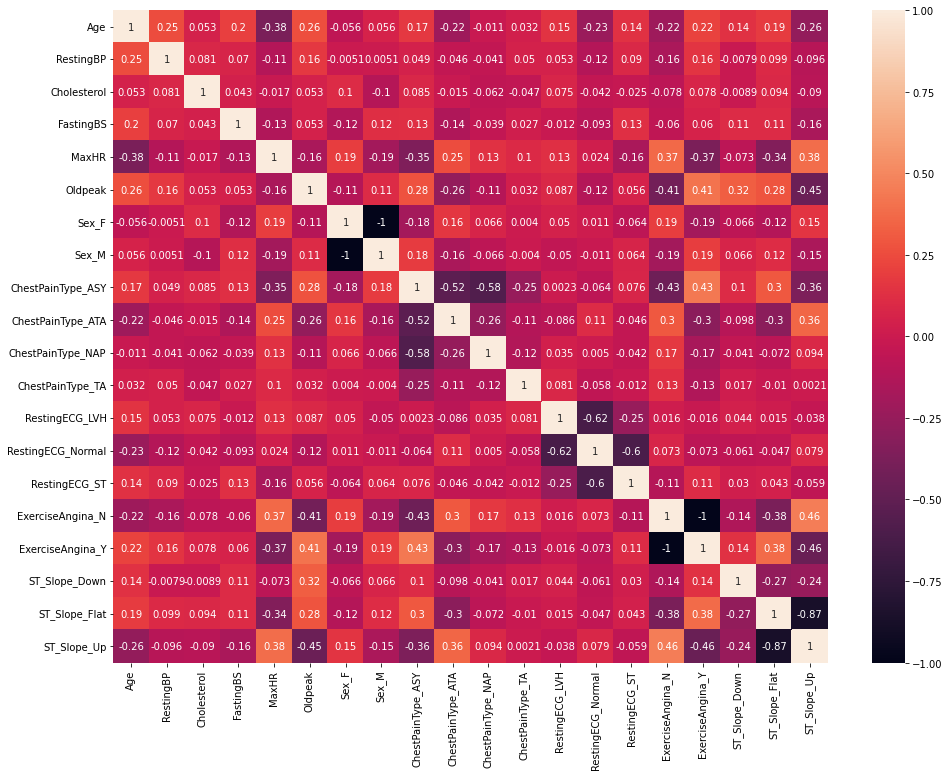

In [483]:
# Matriz de correlação
import seaborn as sns
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True);

É redundante possuir uma feature 'Sex_M' já existindo uma 'Sex_F', o mesmo ocorre com a feature 'ExerciseAngina_N' em que o já existe a feature complementar 'ExerciseAngina_Y'. Dessa forma, como uma é mutuamente exclusiva da outra, suas correlações são -1, então, eliminaremos essas colunas.

In [484]:
df.drop(['ExerciseAngina_N'],axis=1, inplace=True)
df.drop(['Sex_M'],axis=1, inplace=True)

x = df.iloc[:, :]

In [485]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 

# Avaliação dos modelos e ensemble

Árvore de decisão

In [486]:
# Report dos modelos
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
def report_metrics(y_pred, y_test):
    print(
        f" Accuracy:{accuracy_score(y_test,y_pred)}\n",
        f"F1:{f1_score(y_test,y_pred)}\n",
        f"Recall:{recall_score(y_test,y_pred)}\n",
        f"Precision:{precision_score(y_test,y_pred)}\n"
        )

In [487]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4)
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

Foram testados alguns valores diferentes para a profundidade da árvore, foi escolhida a profundidade máxima 4, pois valores menores que isso resultavam em underfitting e valores maiores, em overfitting.

In [488]:
y_pred = tree_model.predict(x_test)
report_metrics(y_pred, y_test)

 Accuracy:0.8260869565217391
 F1:0.84251968503937
 Recall:0.8106060606060606
 Precision:0.8770491803278688



In [489]:
feature_names = list(df.columns)
class_names = ['Normal', 'Disease']

A árvore de decisão, quando não muito profunda, resulta em um modelo interpretável, ou seja, conseguimos visualizar como os valores de nossas features, afetam na classificação do modelo. Para um melhor entendimento de como estamos prevendo o y_test, utilizamos a ferramenta graphviz para visualizar a construção da nossa árvore de decisão.

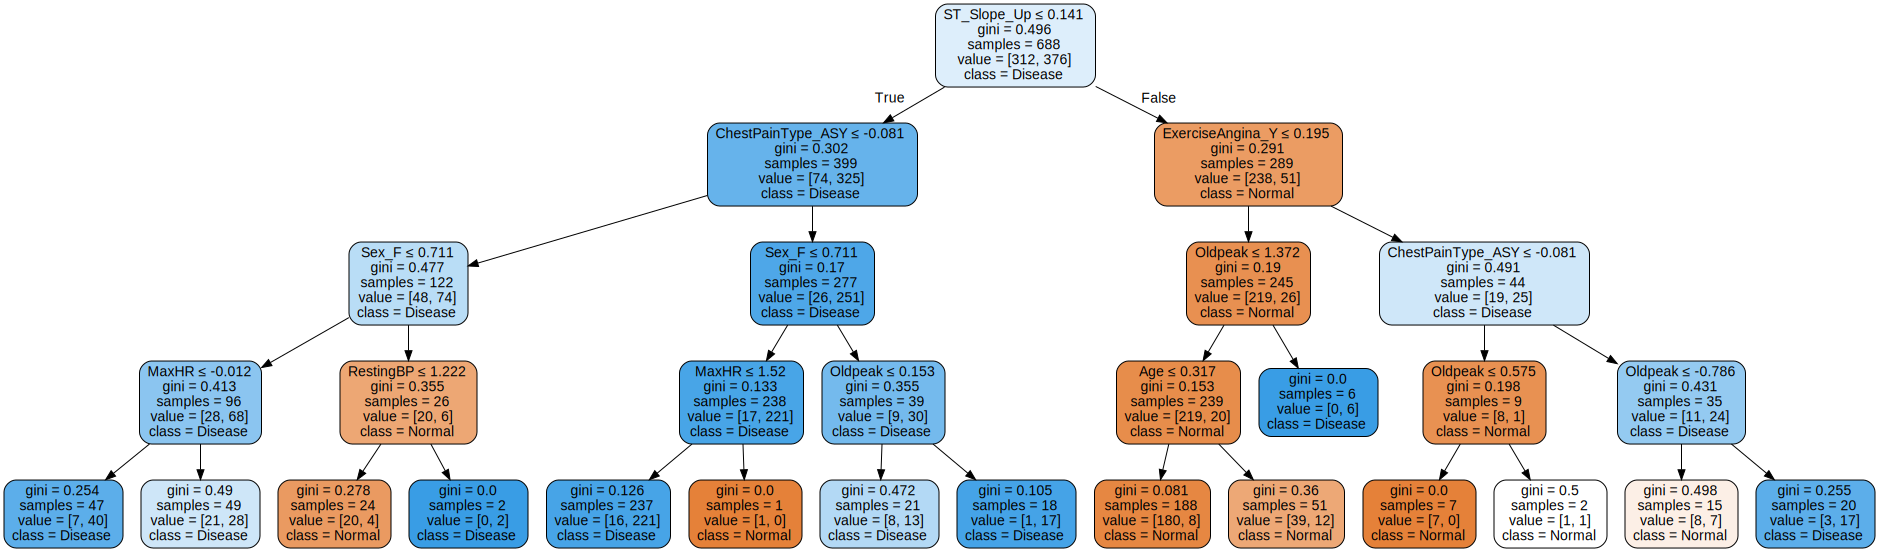

In [490]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(tree_model, 
                  feature_names=feature_names,  
                  class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

K-Nearest Neighbors

In [491]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn_model,         
                    param_grid = {'n_neighbors': [3,4,5,6,7]},
                    scoring = 'accuracy',
                    cv = 10)

Utilizamos o Grid Search para buscar o melhor K para o algoritmo, ou seja, o número de vizinhos que mais aumenta a acurácia do classificador.

In [492]:
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7]}, scoring='accuracy')

In [493]:
grid.best_score_

0.8531329923273658

In [494]:
y_pred = grid.predict(x_test)

In [495]:
report_metrics(y_pred,y_test)

 Accuracy:0.8521739130434782
 F1:0.865079365079365
 Recall:0.8257575757575758
 Precision:0.9083333333333333



Regressão Logística

In [496]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train, y_train)

y_pred = log_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [497]:
accuracy

0.8652173913043478

Naive-Bayes

In [498]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

y_pred = nb_model.predict(x_test)

In [499]:
report_metrics(y_pred,y_test)

 Accuracy:0.8434782608695652
 F1:0.8571428571428572
 Recall:0.8181818181818182
 Precision:0.9



SVM

In [500]:
from sklearn.svm import SVC
svm_model = SVC()
grid = GridSearchCV(estimator = svm_model,         
                    param_grid = {'kernel': ['poly','rbf','linear','sigmoid']},
                    scoring = 'accuracy',
                    cv = 10)

Utilizamos, assim como no algoritmo KNN, o grid search na SVM, para buscar o kernel que resultava em uma maior acurácia do classificador.

In [501]:
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'kernel': ['poly', 'rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [502]:
grid.best_params_

{'kernel': 'linear'}

In [503]:
grid.best_score_

0.858930093776641

In [504]:
y_pred = grid.predict(x_test)
report_metrics(y_pred,y_test)

 Accuracy:0.8565217391304348
 F1:0.8715953307392996
 Recall:0.8484848484848485
 Precision:0.896



XGBoost

In [505]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [506]:
report_metrics(y_pred,y_test)

 Accuracy:0.9
 F1:0.9105058365758756
 Recall:0.8863636363636364
 Precision:0.936



## Avaliacao do ensemble

Quando temos classificadores com acurácia similar que possuem erros diferentes, uma tática comum para um melhor modelo é o "voto da maioria" o que em machine learning é chamado de ensemble de modelos. Vamos testar alguns a fim de tentar obter um melhor resultado.

In [507]:
from sklearn.ensemble import VotingClassifier

ensemble_1 = VotingClassifier(estimators=[
                            ('svm', svm_model), ('nb', nb_model), ('xgb', xgb_model)], voting='hard')

In [508]:
ensemble_1.fit(x_train, y_train)

VotingClassifier(estimators=[('svm', SVC()), ('nb', GaussianNB()),
                             ('xgb', XGBClassifier())])

In [509]:
y_pred = ensemble_1.predict(x_test)
report_metrics(y_pred,y_test)

 Accuracy:0.8652173913043478
 F1:0.8793774319066149
 Recall:0.8560606060606061
 Precision:0.904



Utilizamos a classe VotingClassifier para realizar o ensemble, contudo, o modelo que é a combinação dos 3 melhores não foi suficiente para superar a acurácia do XGBoost.